In [1]:
%matplotlib notebook
import numpy as np
import networkx as nx
import pandas as pd
import random
from matplotlib import pyplot as plt, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm
from joblib import Parallel, delayed
from copy import copy

from synthetic_data import load_data_by_gtype
from graph_generator import add_p_and_delta
from ic import simulated_infection_time_3d, make_partial_cascade
from source_likelihood_estimation_experiment import source_likelihood_ratios_and_dists

In [2]:
gtype = 'kr-hier'
param = '2-6'
N1 = 100  # experiment round
N2 = 500  # simulation rounds
p = 0.7
q = 0.01
g = load_data_by_gtype(gtype, param)[0]
print('|V|={}'.format(g.number_of_nodes()))

|V|=64


In [3]:
ps = np.linspace(0.1, 1.0, 10)
qs = np.linspace(0.1, 1.0, 10)
qs = [1.0]

In [4]:
inf_time_3d_by_p = {p: simulated_infection_time_3d(add_p_and_delta(g, p, 1), N2) for p in ps}

100%|██████████| 500/500 [00:00<00:00, 2121.26it/s]


In [5]:
rows = Parallel(n_jobs=-1)(delayed(source_likelihood_ratios_and_dists)(
    g, p, q, N1, N2, inf_time_3d_by_p[p],
    estimation_method='1st',
    debug=False)
                           for p in tqdm(ps) for q in qs)


100%|██████████| 10/10 [00:00<00:00, 62.84it/s]


In [6]:
rows_linear_weight = Parallel(n_jobs=-1)(delayed(source_likelihood_ratios_and_dists)(
    g, p, q, N1, N2, inf_time_3d_by_p[p],
    estimation_method='1st_time',
    time_weight_func='linear',
    debug=False)
                           for p in tqdm(ps) for q in qs)


100%|██████████| 10/10 [00:00<00:00, 104.44it/s]


In [7]:
rows_inverse_weight = Parallel(n_jobs=-1)(delayed(source_likelihood_ratios_and_dists)(
    g, p, q, N1, N2, inf_time_3d_by_p[p],
    estimation_method='1st_time',
    time_weight_func='inverse',
    debug=False)
                           for p in tqdm(ps) for q in qs)


100%|██████████| 10/10 [00:00<00:00, 48.07it/s]


[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
[1.0]


<IPython.core.display.Javascript object>


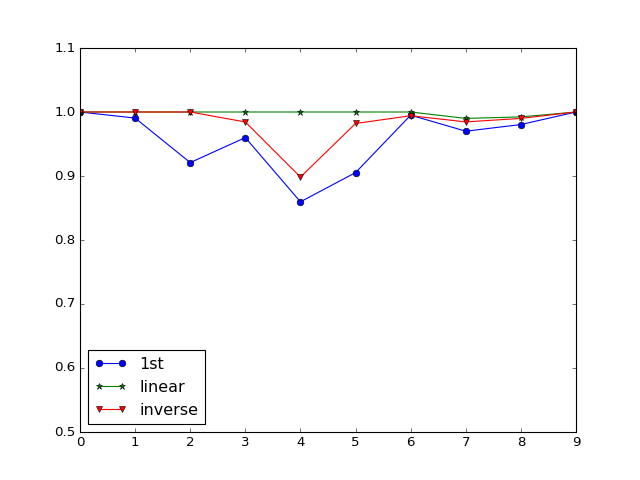

(0.5, 1.1)

In [13]:
print(ps)
print(qs)
fig, ax = plt.subplots(1,1)
ax.plot(np.array([r['ratio']['mean'] for r in rows]), '-o')
ax.plot(np.array([r['ratio']['mean'] for r in rows_linear_weight]), '-*')
ax.plot(np.array([r['ratio']['mean'] for r in rows_inverse_weight]), '-v')
ax.legend(['1st', 'linear', 'inverse'], loc='best')
ax.set_ylim(0.5, 1.1)

In [ ]:
# mpld3.enable_notebook()
fig = plt.figure()
X, Y = np.meshgrid(ps, qs)
ratio_median = np.array([r['ratio']['50%'] for r in rows]).reshape((len(ps), len(qs)))
ratio_mean = np.array([r['ratio']['mean'] for r in rows]).reshape((len(ps), len(qs)))
dist_median = np.array([r['dist']['50%'] for r in rows]).reshape((len(ps), len(qs)))
dist_mean = np.array([r['dist']['mean'] for r in rows]).reshape((len(ps), len(qs)))
to_draw_data = {
    'ratio-median': ratio_median,
    'ratio-mean': ratio_mean,
    'dist-median': dist_median,
    'dist-mean': dist_mean,
}

Z = ratio_mean
name = 'ratio-mean'
plt.clf()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, 
                       rstride=1, cstride=1,
                       vmin=0, vmax=1,
                       cmap=cm.coolwarm)
ax.set_zlim(0, Z.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)    

ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_zlabel(name)
plt.show()


In [ ]:
np.savez('figs/{}/source-likelihood-vs-p-and-q-data'.format(gtype), [X, Y, ratio_median, ratio_mean, dist_median, dist_mean])

In [ ]:
for p in np.linspace(0.1, 0.9, 9):
    probas = np.power(p, np.arange(1, 6))
    probas = probas / probas.sum()
    print(p, probas)